In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.models
from keras.layers.convolutional import Conv1D, ZeroPadding1D
from keras.layers.recurrent import Recurrent, LSTM, GRU
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from math import floor, ceil
from sklearn.metrics import accuracy_score
import keras.backend as tf
% matplotlib inline

Using TensorFlow backend.


# preprocess

In [9]:
PAD_WITH_DERIV = True
def pad_with_deriv(x_train):
    x_deriv = np.zeros(x_train.shape)
    x_deriv[:,:-1,:] = np.diff(x_train,axis=1)
    x_train_2 = np.zeros((x_train.shape[0],x_train.shape[1],2))
    x_train_2[:,:,0] = x_train[:,:,0]
    x_train_2[:,:,1] = x_deriv[:,:,0]
    return x_train_2

def load_and_format_data():
    # load data
    x_train = np.array([])
    y_train = np.array([])
    for i in ['7']:
        dataset = 'train/'+str(i)
        x_data = pd.read_csv(dataset + '.train.calcium.csv')
        y_data = pd.read_csv(dataset + '.train.spikes.csv')    
        for key in x_data:
            x_train = np.concatenate((x_train,x_data[key].dropna()))
            y_train = np.concatenate((y_train,y_data[key].dropna()))
    x_test = pd.read_csv('train/10' + '.train.calcium.csv')['9'].dropna()
    y_test = pd.read_csv('train/10' + '.train.spikes.csv')['9'].dropna()
    num_y = int(np.max(y_train+1))
    # binarize labels
    lb = LabelBinarizer()
    lb.fit(y_train) # this lb takes 0 -> [1,0,0,0,0], 1-> [0,1,0,0,0], etc.
    y_train_orig = y_train
    y_train = lb.transform(y_train)
#     y_test = lb.transform(y_test)
    # reshape data
    x_train = x_train.reshape((1, len(x_train), 1))
    y_train = y_train.reshape((1, len(y_train), y_train.shape[1]))
    x_test = x_test.values.reshape((1, len(x_test), 1))
#     y_test = y_test.reshape((1, len(y_test), y_test.shape[1]))
    if PAD_WITH_DERIV:
        x_train = pad_with_deriv(x_train)
        x_test = pad_with_deriv(x_test)
    return x_train, y_train, x_test, y_test, y_train_orig, num_y
x_train, y_train, x_test, y_test, y_train_orig, num_y = load_and_format_data()
print("train, test sizes",x_train.shape,x_test.shape)

train, test sizes (1, 884682, 2) (1, 9698, 2)


In [3]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def pos_acc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    return tp/(tp+fn)

def neg_acc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    return tn/(tn+fp)

# create model

In [6]:
sample_weight = np.ones((1,len(y_train_orig)))
sample_weight[0,y_train_orig==0]=0.1/100
kernel_sizes = [31,31,31] # should be odd
pad_sizes = [floor(s/2) for s in kernel_sizes]
model = keras.models.Sequential()
model.add(ZeroPadding1D(padding=pad_sizes[0], input_shape=(None, x_train.shape[-1])))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[0], activation="linear"))
model.add(ZeroPadding1D(padding=pad_sizes[1], input_shape=(None, x_train.shape[-1])))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[1], activation="linear"))
model.add(ZeroPadding1D(padding=pad_sizes[2], input_shape=(None, x_train.shape[-1])))
model.add(Conv1D(filters=num_y, kernel_size=kernel_sizes[2], activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',pos_acc,neg_acc],
              sample_weight=sample_weight, sample_weight_mode="temporal")

# fit the model

In [7]:
epochs = 20
model.fit(x_train, y_train, epochs=epochs, verbose=1,initial_epoch=0)

Epoch 1/20
1/1 [==============================] - 2s - loss: 1.3684 - acc: 0.3366 - pos_acc: 5.2109e-04 - neg_acc: 0.9997
Epoch 2/20
1/1 [==============================] - 1s - loss: 1.3133 - acc: 0.7390 - pos_acc: 0.0047 - neg_acc: 0.9999
Epoch 3/20
1/1 [==============================] - 1s - loss: 1.2633 - acc: 0.9101 - pos_acc: 0.0106 - neg_acc: 0.9999
Epoch 4/20
1/1 [==============================] - 1s - loss: 1.2097 - acc: 0.9664 - pos_acc: 0.0204 - neg_acc: 0.9998
Epoch 5/20
1/1 [==============================] - 1s - loss: 1.1530 - acc: 0.9806 - pos_acc: 0.0348 - neg_acc: 0.9996
Epoch 6/20
1/1 [==============================] - 1s - loss: 1.0885 - acc: 0.9853 - pos_acc: 0.0560 - neg_acc: 0.9994
Epoch 7/20
1/1 [==============================] - 1s - loss: 1.0165 - acc: 0.9871 - pos_acc: 0.0859 - neg_acc: 0.9991
Epoch 8/20
1/1 [==============================] - 1s - loss: 0.9358 - acc: 0.9881 - pos_acc: 0.1274 - neg_acc: 0.9989
Epoch 9/20
1/1 [==============================] - 1s

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/keras/backend/tensorflow_backend.py:2124: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


# evaluate

----------training----------
pred nonzeros	 0.00978995842574
acc		 0.990002057236
corr		 -0.00484119517042
----------testing----------
pred nonzeros	 0.0
acc		 0.971746751908
corr		 nan


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


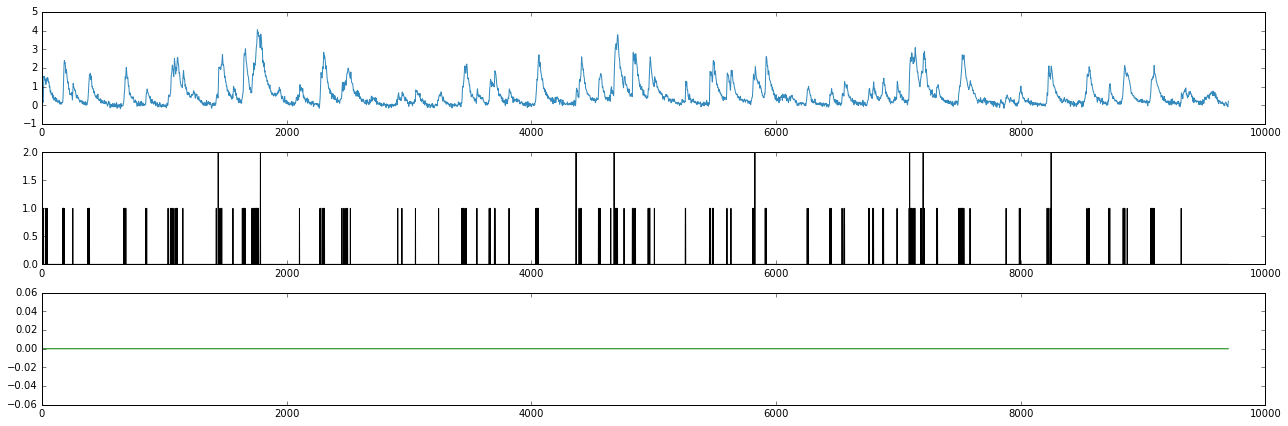

In [19]:
def visualize(calcium, spikes, spikes2=None):
    plt.figure(figsize=(18, 6))
    t = np.arange(len(calcium))
    plt.hold(True)
    if spikes2==None:
        plt.subplot(211)
        plt.plot(t, calcium, color='#348ABD')
        plt.subplot(212)
        plt.plot(t, spikes, color='black',label='gt')
    else:
        plt.subplot(311)
        plt.plot(t, calcium, color='#348ABD')
        plt.subplot(312)
        plt.plot(t, spikes, color='black',label='gt')
        plt.subplot(313)
        plt.plot(t, spikes2, color='g',label='pred')
#     plt.ylim([-6, 3])
    plt.xlim([0,10000])
    plt.tight_layout()
    plt.show()
    
def corr(gt, pred):
    return np.corrcoef(gt,pred)[0,1]

print('----------training----------')
y_pred = np.argmax(model.predict(x_train)[0,:,:],axis=1)
print('pred nonzeros\t',str(np.sum(y_pred) / y_pred.size))
print("acc\t\t",accuracy_score(y_pred,y_train_orig))
print("corr\t\t",corr(y_pred,np.argmax(y_train[0,:,:],axis=1)))

print('----------testing----------')
y_pred = np.argmax(model.predict(x_test)[0,:,:],axis=1)
print('pred nonzeros\t',str(np.sum(y_pred) / y_pred.size))
print("acc\t\t",accuracy_score(y_pred,y_test))
print("corr\t\t",corr(y_pred,y_test))
visualize(x_test[0,:,0],y_test,y_pred)